In [1]:
import os
import json
import pathlib
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import functools
from sklearn.metrics import cohen_kappa_score, root_mean_squared_error
import lightgbm as lgb
from typing import List, Dict, Union, Tuple, NamedTuple
from tqdm import tqdm
import scml
import matplotlib.pyplot as plt
import lalaes2 as mylib

In [2]:
version = "01"
num_boost_round = 1000
stopping_rounds = 20
feature_fraction = 1.0
max_leaves = 32
learning_rate = 0.1
device = "cpu"
with open(f"input/features_{version}.json") as f:
    metadata = json.load(f)
feature_names = metadata["feature_names"]

In [3]:
tim = scml.Timer()
tim.start()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
percentiles=[.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99]
pd.set_option("max_info_columns", 9999)
pd.set_option("display.max_columns", 9999)
pd.set_option("display.max_rows", 9999)
pd.set_option('max_colwidth', 9999)
tqdm.pandas()
scml.seed_everything()
info = np.iinfo(np.int16)
print(f"int16, min={info.min}, max={info.max}")
job_ts = datetime.now().strftime('%Y%m%d_%H%M%S')
job_dir = pathlib.Path("models/lgb") / job_ts
job_dir.mkdir(parents=True, exist_ok=True)
print(f"job_dir={str(job_dir)}")

int16, min=-32768, max=32767
job_dir=models/lgb/20240616_154117


In [4]:
print(f"{len(feature_names)} features\n{feature_names}")

27 features
['cw_digit_frac', 'cw_len', 'cw_letter_frac', 'cw_punc_frac', 'cw_repeat_char_frac', 'cw_repeat_substring_frac', 'cw_space_frac', 'cw_stopword_frac', 'cw_unique_word_frac', 'cw_upper_frac', 'deberta_base', 'ts_automated_readability_index', 'ts_coleman_liau_index', 'ts_dale_chall_readability_score', 'ts_flesch_kincaid_grade', 'ts_flesch_reading_ease', 'ts_gunning_fog', 'ts_lexicon_count', 'ts_linsear_write_formula', 'ts_mcalpine_eflaw', 'ts_sentence_count', 'ts_smog_index', 'ts_syllable_count', 'ts_syllables_per_sent', 'ts_syllables_per_word', 'ts_text_standard', 'ts_words_per_sent']


In [6]:
#TODO remove
feature_names.remove("deberta_base")

In [7]:
tra = pd.read_parquet(f"input/mtra_{version}.parquet")
tra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16441 entries, 0 to 16440
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   essay_id                         16441 non-null  object 
 1   score                            16441 non-null  int8   
 2   deberta_base                     16441 non-null  float32
 3   cw_len                           16441 non-null  float32
 4   cw_digit_frac                    16441 non-null  float32
 5   cw_letter_frac                   16441 non-null  float32
 6   cw_space_frac                    16441 non-null  float32
 7   cw_punc_frac                     16441 non-null  float32
 8   cw_upper_frac                    16441 non-null  float32
 9   cw_repeat_char_frac              16441 non-null  float32
 10  cw_repeat_substring_frac         16441 non-null  float32
 11  cw_unique_word_frac              16441 non-null  float32
 12  cw_stopword_frac  

In [8]:
val = pd.read_parquet(f"input/mval_{version}.parquet")
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   essay_id                         866 non-null    object 
 1   score                            866 non-null    int8   
 2   deberta_base                     866 non-null    float32
 3   cw_len                           866 non-null    float32
 4   cw_digit_frac                    866 non-null    float32
 5   cw_letter_frac                   866 non-null    float32
 6   cw_space_frac                    866 non-null    float32
 7   cw_punc_frac                     866 non-null    float32
 8   cw_upper_frac                    866 non-null    float32
 9   cw_repeat_char_frac              866 non-null    float32
 10  cw_repeat_substring_frac         866 non-null    float32
 11  cw_unique_word_frac              866 non-null    float32
 12  cw_stopword_frac      

In [9]:
tra_ds = lgb.Dataset(tra[feature_names], label=tra["score"])
val_ds = lgb.Dataset(val[feature_names], label=val["score"])
eval_result = {}
b = lgb.train(
    {
        "objective": "rmse",
        "feature_fraction": feature_fraction,
        "bagging_fraction": 1.0,
        "learning_rate": learning_rate,
        "min_data_in_leaf": 20,
        "max_leaves": max_leaves,
        "metric": ["rmse"],
        "is_training_metric": True,
        "force_col_wise": True,  # used only with cpu device type
        "verbose": 1,  # -1 to mute
        "device": device,
        # small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)
        # recommended to use the smaller max_bin (e.g. 63) to get the better speed up
        "max_bin": 255,
    },
    tra_ds,
    valid_sets=[tra_ds, val_ds],
    num_boost_round=num_boost_round,
    callbacks=[
        lgb.record_evaluation(eval_result=eval_result),
        lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
    ],
)
fp = job_dir / "lgb.txt"
b.save_model(str(fp))
print(f"Saved {fp}")

[LightGBM] [Info] Total Bins 6042
[LightGBM] [Info] Number of data points in the train set: 16441, number of used features: 26
[LightGBM] [Info] Start training from score 2.948422
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	training's rmse: 0.56886	valid_1's rmse: 0.653952
Saved models/lgb/20240616_154117/lgb.txt


# Loss Curves

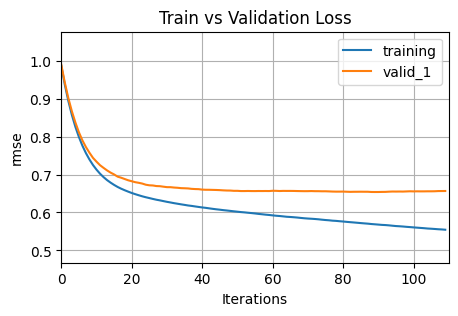

In [10]:
lgb.plot_metric(
    eval_result, 
    metric="rmse", 
    figsize=(5, 3),
    title="Train vs Validation Loss",
)
plt.show()

# Evaluation and Best Thresholds

Competition Metric: Quadratic Weighted Kappa

In [11]:
%%time
logits = b.predict(val[feature_names])

CPU times: user 34.1 ms, sys: 12.4 ms, total: 46.5 ms
Wall time: 7.38 ms


In [12]:
y_true = val["score"].tolist()
thresholds = mylib.optimize_thresholds(y_true=y_true, logits=logits)
qwk = mylib.qwk_metric(y_true=y_true, logits=logits, thresholds=thresholds)
rmse = root_mean_squared_error(y_true, logits)
print(f"QWK={qwk:.4f}\nRMSE={rmse:.4f}\nthresholds={thresholds}")

QWK=0.7552
RMSE=0.6540
thresholds=[1.743238575783585, 2.5301881943700484, 3.485036856924266, 4.217883576657888, 5.038322732314704]


# Feature Importance

In [13]:
scores = b.feature_importance().tolist()
rows = []
for i in range(len(scores)):
    rows.append({'importance': scores[i], 'feature': feature_names[i]})
df = pd.DataFrame.from_records(rows)
df = df.sort_values('importance', ascending=False, ignore_index=True)
_path = job_dir / "features.csv"
df.to_csv(_path, index=True)
print(f"\nSaved {_path}")
display(df.T.head())


Saved models/lgb/20240616_154117/features.csv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
importance,222,211,189,181,164,163,155,144,129,123,123,113,109,94,84,81,73,68,65,55,55,53,42,42,33,19
feature,ts_dale_chall_readability_score,cw_punc_frac,cw_upper_frac,cw_digit_frac,ts_syllable_count,cw_unique_word_frac,cw_space_frac,cw_stopword_frac,cw_letter_frac,cw_repeat_char_frac,ts_syllables_per_word,ts_linsear_write_formula,cw_repeat_substring_frac,ts_smog_index,cw_len,ts_sentence_count,ts_coleman_liau_index,ts_lexicon_count,ts_mcalpine_eflaw,ts_words_per_sent,ts_gunning_fog,ts_syllables_per_sent,ts_flesch_reading_ease,ts_automated_readability_index,ts_flesch_kincaid_grade,ts_text_standard


In [14]:
tim.stop()
print(f"Total time taken {str(tim.elapsed)}")

Total time taken 0:00:16.724960
